In [1]:
#Library Imports
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#Get the NYSE Trading Calendar
nyse = mcal.get_calendar("NYSE")

trading_days = nyse.valid_days(
    start_date = "1927-12-30",
    end_date = "2025-08-31"
)

trading_days = trading_days.tz_localize(None).normalize() #get rid of local time zones to match Bloomberg data format
trading_days = trading_days[trading_days.dayofweek < 5] #Exclude weekends

print(trading_days) #gets specifically the dates

DatetimeIndex(['1927-12-30', '1928-01-03', '1928-01-04', '1928-01-05',
               '1928-01-06', '1928-01-09', '1928-01-10', '1928-01-11',
               '1928-01-12', '1928-01-13',
               ...
               '2025-08-18', '2025-08-19', '2025-08-20', '2025-08-21',
               '2025-08-22', '2025-08-25', '2025-08-26', '2025-08-27',
               '2025-08-28', '2025-08-29'],
              dtype='datetime64[us]', length=24532, freq=None)


In [10]:
#Load S&P500 Bloomberg Data
sp500df = pd.read_excel(
    "sp500_data.xlsx",
    header = 5, #header on 6th row
    parse_dates = ["Date"]
)

# print(sp500df.head())
# print(sp500df.tail())
# print(sp500df.dtypes)

In [11]:
#A Series of Data Checks

#Check for missing data in the Bloomberg dataset itself
print(sp500df.isna().sum())
print(sp500df["Date"].min(), sp500df["Date"].max())
print(f'S&P500 Bloomberg data currently has {len(sp500df)} rows \n')

#Check for any missing trading days from Bloomberg
sp500df = sp500df.set_index("Date").sort_index() #Set the chronological dates as the index
sp500df = sp500df.reindex(trading_days) #Fills in N/A if trading days don't have corresponding S&P500 data
print(sp500df.isna().sum())
print(f'S&P500 Bloomberg data currently has {len(sp500df)} rows \n')

# print(sp500df.head())
# print(sp500df.tail())
print(sp500df[sp500df.isna().any(axis = 1)]) #Print the missing row
print("\n")

#Check for intraday identical price reporting
num_ids = sp500df[["PX_OPEN", "PX_HIGH", "PX_LOW", "PX_LAST"]].nunique(axis = 1)
id_bool = num_ids > 1
first_unique = id_bool.idxmax()
print(f'The first date with non-identical price reporting is {first_unique} \n')

id_after = num_ids.loc[first_unique:].eq(1)
print(f'Any identical OHLC price reports after the first day: {id_after.any()}')
print(f'Number of identical OHLC price reports after first day: {id_after.sum()}')
id_dates = id_after[id_after].index
print(f'Dates with identical OHLC price reports after first day: {id_dates}')


Date       0
PX_OPEN    0
PX_HIGH    0
PX_LOW     0
PX_LAST    0
dtype: int64
1927-12-30 00:00:00 2025-08-29 00:00:00
S&P500 Bloomberg data currently has 24533 rows 

PX_OPEN    1
PX_HIGH    1
PX_LOW     1
PX_LAST    1
dtype: int64
S&P500 Bloomberg data currently has 24532 rows 

            PX_OPEN  PX_HIGH  PX_LOW  PX_LAST
1928-11-07      NaN      NaN     NaN      NaN


The first date with non-identical price reporting is 1982-04-21 00:00:00 

Any identical OHLC price reports after the first day: True
Number of identical OHLC price reports after first day: 1
Dates with identical OHLC price reports after first day: DatetimeIndex(['1989-06-12'], dtype='datetime64[us]', freq=None)


Over the chosen sample period, the sample probability that the market daily lowest value occurs at open is 13.826866764275255%
Over the chosen sample period, the sample probability that the market daily highest value occurs at close is 5.591142020497804%
count    10866.000000
mean         0.056036
std          0.046898
min          0.000000
25%          0.015873
50%          0.047619
75%          0.095238
max          0.206349
Name: HIGH_CLOSE, dtype: float64
count    10866.000000
mean         0.138697
std          0.061335
min          0.000000
25%          0.095238
50%          0.142857
75%          0.190476
max          0.301587
Name: LOW_OPEN, dtype: float64


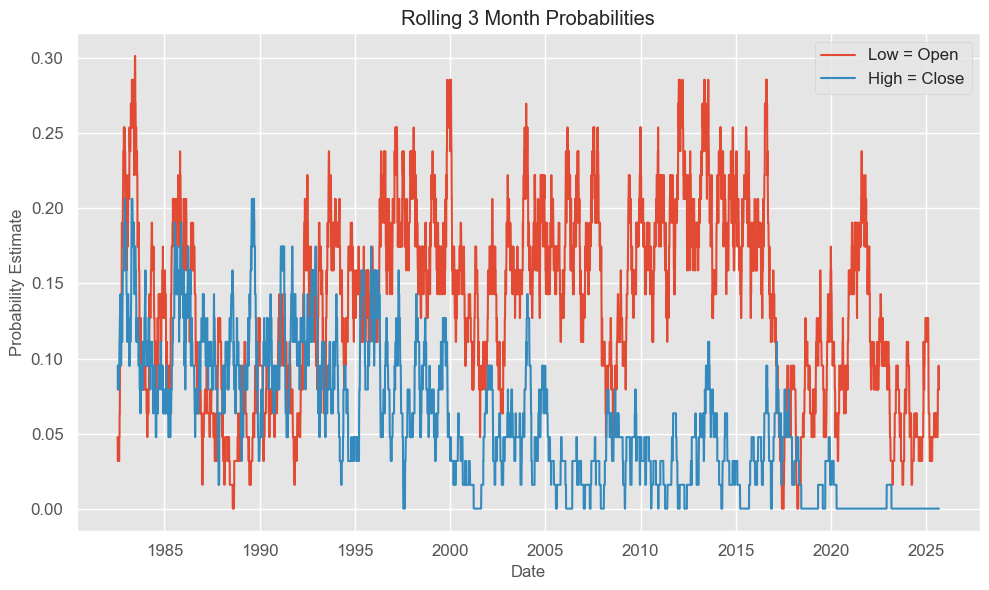

In [23]:
#Probability Estimates
prob_sp500df = sp500df.loc["1982-04-21":].copy() #Consider OHLC data from 4/21/1982 onwards
prob_sp500df = prob_sp500df.drop(index = "1989-06-12") #Drop the one date in this time period that had identical OHLC data

prob_sp500df["LOW_OPEN"] = (prob_sp500df["PX_LOW"] == prob_sp500df["PX_OPEN"])
prob_sp500df["HIGH_CLOSE"] = (prob_sp500df["PX_HIGH"] == prob_sp500df["PX_LAST"])

#Start with overall sample means
p_low_open = prob_sp500df["LOW_OPEN"].mean()
p_high_close = prob_sp500df["HIGH_CLOSE"].mean()

print(f'Over the chosen sample period, the sample probability that the market daily lowest value occurs at open is {p_low_open * 100}%')
print(f'Over the chosen sample period, the sample probability that the market daily highest value occurs at close is {p_high_close * 100}%')

#Do rolling windows on 3 month scale to test robustness to time variation
rolling_p_low = prob_sp500df["LOW_OPEN"].rolling(63).mean()
rolling_p_high = prob_sp500df["HIGH_CLOSE"].rolling(63).mean()

print(rolling_p_high.describe())
print(rolling_p_low.describe())

plt.style.use('ggplot')
#Plot rolling window estimate to see time variation
plt.figure()
plt.plot(prob_sp500df.index, rolling_p_low, label = "Low = Open")
plt.plot(prob_sp500df.index, rolling_p_high, label = "High = Close")
plt.title("Rolling 3 Month Probabilities")
plt.ylabel("Probability Estimate")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
#Intraday Range Calculations
sp500df["PX_INTRADAY"] = (sp500df["PX_HIGH"] - sp500df["PX_LOW"]) / sp500df["PX_LOW"]

intra_start = "1980-01-01"
intra_end = "2011-08-31"

intra_sp500df = sp500df.loc[intra_start:intra_end]

top20_intraday = intra_sp500df.nlargest(20, "PX_INTRADAY")
print(top20_intraday)

subperiod = top20_intraday.index.to_series().between("2008-09-01", "2011-08-31").sum()
print(f'{subperiod} of the top 20 intraday ranges happened during the final three-year sub-period during / after the 2008 crisis')

            PX_OPEN  PX_HIGH   PX_LOW  PX_LAST  PX_INTRADAY
1987-10-19   282.70   282.70   224.83   224.84     0.257394
1987-10-20   225.06   245.62   216.46   236.83     0.134713
2008-11-13   853.13   913.01   818.69   911.29     0.115208
2008-10-10   902.31   936.36   839.80   899.22     0.114980
2008-10-28   848.92   940.51   845.27   940.51     0.112674
2008-10-09   988.42  1005.25   909.19   909.92     0.105654
2008-10-13   912.75  1006.93   912.75  1003.35     0.103183
2008-10-15   994.60   994.60   903.99   907.84     0.100233
2008-11-20   805.87   820.52   747.78   752.44     0.097275
2010-05-06  1164.38  1167.58  1065.79  1128.15     0.095507
1987-10-21   236.83   259.26   236.83   258.38     0.094709
2008-10-16   909.53   947.71   865.83   946.43     0.094568
2008-09-29  1209.07  1209.07  1106.39  1106.39     0.092806
1987-10-26   248.20   248.22   227.26   227.67     0.092229
2008-12-01   888.61   888.61   815.69   816.21     0.089397
2008-10-06  1097.56  1097.56  1007.97  1

In [14]:
#Overnight Return Calculations

#Helper function to return a string of three year buckets from an array of years
def three_year_buckets(idx):
    start_bucket = (idx.year // 3) * 3
    return start_bucket.astype(str) + "-" + (start_bucket + 2).astype(str)

sp500df["CLOSE_OPEN_R"] = (sp500df["PX_OPEN"] - sp500df["PX_LAST"].shift(1)) / sp500df["PX_LAST"].shift(1)

ret_start = "1980-01-01"
ret_start2 = "1982-04-21" #second return start date when the intraday range becomes nonzero - data might be more accurate starting this period
ret_end = "2011-08-31"

returndf = sp500df.loc[ret_start2:ret_end]

top20_pos = returndf.nlargest(20, "CLOSE_OPEN_R")
top20_neg = returndf.nsmallest(20, "CLOSE_OPEN_R")
print(top20_pos)
print(top20_neg)

pos_counts = three_year_buckets(top20_pos.index).value_counts()
neg_counts = three_year_buckets(top20_neg.index).value_counts()

print(f'\n{pos_counts.idxmax()} has the largest number of positive overnight returns')
print(f'\n{neg_counts.idxmax()} has the largest number of negative overnight returns')

            PX_OPEN  PX_HIGH   PX_LOW  PX_LAST  PX_INTRADAY  CLOSE_OPEN_R
2008-10-13   912.75  1006.93   912.75  1003.35     0.103183      0.015046
1984-08-03   160.28   162.56   157.99   162.35     0.028926      0.014495
1982-06-11   111.11   111.48   109.65   111.24     0.016689      0.013685
1982-08-17   105.40   109.33   104.32   109.04     0.048025      0.012585
1988-12-05   274.93   275.62   271.81   274.93     0.014017      0.011479
2010-05-10  1122.27  1163.85  1122.27  1159.73     0.037050      0.010244
2008-10-30   939.38   963.23   928.50   954.09     0.037404      0.009988
1982-05-06   118.82   118.83   117.68   118.68     0.009772      0.009773
1983-11-02   165.21   165.21   163.55   164.84     0.010150      0.009594
2008-12-08   882.71   918.57   882.71   909.70     0.040625      0.007579
1982-04-23   118.02   118.64   117.19   118.64     0.012373      0.007083
2007-12-12  1487.58  1511.96  1468.23  1486.59     0.029784      0.006720
1982-06-30   110.95   111.00   109.50 

In [15]:
#Market Jump Volatility
sp500df["LOG_R"] = np.log(sp500df["PX_LAST"] / sp500df["PX_LAST"].shift(1))
sp500df["STDEV30"] = sp500df["LOG_R"].rolling(window = 30).std().shift(1)
sp500df["JUMP"] = sp500df["LOG_R"] / sp500df["STDEV30"]
# print(sp500df.head())
# print(sp500df.tail())

ret_start = "1980-01-01"
ret_start2 = "1982-04-21" #second return start date when the intraday range becomes nonzero - data might be more accurate starting this period
ret_end = "2011-08-31"

returndf = sp500df.loc[ret_start2:ret_end]

top20_jumps = returndf.assign(ABS_JUMP = returndf["JUMP"].abs()).nlargest(20, "ABS_JUMP")
print(top20_jumps)

sub_jumps = top20_jumps.index.to_series().between("2008-09-01", "2011-08-31").sum()
print(f'\n{sub_jumps} of the top 20 jumps happened during the 9/2008-9/2011 period')

            PX_OPEN  PX_HIGH   PX_LOW  PX_LAST  PX_INTRADAY  CLOSE_OPEN_R  \
1987-10-19   282.70   282.70   224.83   224.84     0.257394      0.000000   
1989-10-13   355.41   355.53   332.81   333.62     0.068267      0.000056   
2007-02-27  1449.25  1449.25  1389.42  1399.04     0.043061     -0.000090   
1997-10-27   941.64   941.64   876.73   876.99     0.074036      0.000000   
1986-09-11   247.06   247.06   234.67   235.18     0.052798      0.000000   
1991-11-15   397.15   397.16   382.62   382.62     0.038001      0.000000   
1982-08-17   105.40   109.33   104.32   109.04     0.048025      0.012585   
1994-02-04   480.68   481.02   469.28   469.81     0.025017     -0.000062   
2000-01-04  1455.22  1455.22  1397.43  1399.42     0.041354      0.000000   
1993-02-16   444.53   444.53   433.47   433.91     0.025515     -0.000112   
2001-09-17  1092.54  1092.54  1037.46  1038.77     0.053091      0.000000   
2011-08-08  1198.48  1198.48  1119.28  1119.46     0.070760     -0.000750   